In [1]:
import numpy as np
import h5py
import random
import os
import sys
import glob
import zipfile
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy.ma as ma
import scipy
import astropy
   
import torch
import torch.nn as nn
import torch.nn.functional as F

sys.path.insert(0, "{}/StarNet".format(os.getenv('HOME')))
from startorch.train_starnet import StarNet
from startorch.utils import *

In [2]:
plt.rcParams['axes.grid']=True
plt.rcParams['grid.color']='gray'
plt.rcParams['grid.alpha']='0.4'
plt.rcParams["text.usetex"] = True

In [3]:
home = os.getenv('HOME')
scratch = os.getenv('SCRATCH')
starnet_training_dir = os.path.join(scratch, 'starnettraining')
wave_grid_dir = os.path.join(scratch, 'wave_grids')

In [4]:
wave_grid_arms = np.load(os.path.join(wave_grid_dir, 'weave_hr_wavegrid_arms.npy'))

In [5]:
# Choose the key in the .h5 file that corresponds to the spectra dataset
spec_key = 'spectra_symnorm_nomask99'

In [6]:
#keys = ['spectra_asymnorm_nomask', 'teff', 'logg', 'feh', 'teff_rvs', 'logg_rvs', 'feh_rvs', 'cname', 'targid']
#keys = ['spectra_asymnorm_nomask99', 'teff', 'logg', 'feh', 'teff_rvs', 'logg_rvs', 'feh_rvs', 'cname', 'targid']
keys = [spec_key, 'teff', 'logg', 'feh', 'teff_rvs', 'logg_rvs', 'feh_rvs', 'vrad_rvs', 'cname', 'targid']

gs_data = {}

with h5py.File('/scratch/merileo/spectra/weaveHR_gs_bgr_newasym_wmaskingw99.h5', 'r') as f:
    for key in keys:
        gs_data[key] = f[key][:]
    print(list(f.keys()))

['alpha', 'alpha_rvs', 'class', 'cname', 'feh', 'feh_rvs', 'logg', 'logg_rvs', 'micro', 'spectra_asymnorm', 'spectra_asymnorm_nomask', 'spectra_asymnorm_nomask99', 'spectra_symnorm_nomask99', 'targid', 'teff', 'teff_rvs', 'vrad_rvs', 'vsini_rvs', 'wprov']


In [7]:
def remove_intraccd_gaps(spectrum):
    spectrum[22400:23450] = np.random.normal(1, .005, np.shape(spectrum[22400:23450]))
    spectrum[34000:35500] = np.random.normal(1, .005, np.shape(spectrum[34000:35500]))
    spectrum[8980:9900] = np.random.normal(1, .005, np.shape(spectrum[8980:9900]))

    return spectrum

In [8]:
# Zero out spectra values that meet certain criteria (same as during training)
gs_data[spec_key][np.isnan(gs_data[spec_key])] = 0
gs_data[spec_key][np.isinf(gs_data[spec_key])] = 0
gs_data[spec_key][gs_data[spec_key] > 2] = 0
gs_data[spec_key][gs_data[spec_key] < 0] = 0

In [9]:
# Remove gaps within the arms
for i, x in enumerate(gs_data[spec_key]):
    x = remove_intraccd_gaps(x)
    gs_data[spec_key][i] = x

In [10]:
# Truncate the spectra if StarNet was trained with truncated spectra
wvl_indices = (wave_grid_arms > 4800) & (wave_grid_arms < 5260)
gs_data[spec_key] = gs_data[spec_key][:, wvl_indices]

# Determine which spectra have no green arm (the missing arms were filled in with noise),
# because these need to be removed if we're using truncated spectra
nogreenarm_indices = np.min(gs_data[spec_key], 1) > 0.96
for key in gs_data.keys():
    gs_data[key] = gs_data[key][~nogreenarm_indices]

spectra_symnorm_nomask99
teff
logg
feh
teff_rvs
logg_rvs
feh_rvs
vrad_rvs
cname
targid


In [11]:
# Get indices for different populations of stars
mp_cool_indices = (gs_data['feh'] < -1.5) & (gs_data['teff'] < 7000) & (np.abs(gs_data['vrad_rvs']) < 100)
mp_cool_giants_indices = (gs_data['feh'] < -1.5) & (gs_data['teff'] < 6000) & (gs_data['logg'] <= 3)
mp_cool_dwarfs_indices = (gs_data['feh'] < -1.5) & (gs_data['teff'] < 6000) & (gs_data['logg'] > 3)
all_stars = gs_data['feh'] < 500

In [12]:
print('Number of metal-poor cool stars: {}'.format(sum(mp_cool_indices)))
print('Number of metal-poor cool giants: {}'.format(sum(mp_cool_giants_indices)))
print('Number of metal-poor cool dwarfs: {}'.format(sum(mp_cool_dwarfs_indices)))

Number of metal-poor cool stars: 94
Number of metal-poor cool giants: 48
Number of metal-poor cool dwarfs: 36


In [13]:
# Choose the stars to test on
chosen_stars = mp_cool_indices

In [14]:
# Load the Golden Sample master table
hdu = fits.open('GA-QAG_OPR3bv3_MasterTableCodev4_GoldenSample_RELEASE.fits', memmap=True)
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                  624 / width of table in bytes                        
NAXIS2  =                11012 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                   73 / number of columns                              
EXTNAME = 'Joined  '           / table name                                     
TTYPE1  = 'OBID    '           / label for column 1                             
TFORM1  = 'K       '           / format for column 1                            
TTYPE2  = 'NAME    '           / label for column 2                             
TFORM2  = '18A     '        

In [15]:
# Collect the input stellar parameters for the Golden Sample
teff_input = []
logg_input = []
feh_input = []
alpha_input = []
vrad_input = []
snr_input = []
for i in range(sum(chosen_stars)):
    inds = np.where(hdu[1].data['CNAME'] == gs_data['cname'][chosen_stars][i].decode('UTF-8'))[0]
    if len(inds) > 0:
        t = hdu[1].data['TEFF_INPUT'][inds][0]
        g = hdu[1].data['LOGG_INPUT'][inds][0]
        f = hdu[1].data['MH_INPUT'][inds][0]
        a = hdu[1].data['ALPHA_INPUT'][inds][0]
        v = hdu[1].data['VRAD_INPUT'][inds][0]
        snr = hdu[1].data['SNR_CASU'][inds][0]
    else:
        t = np.nan
        g = np.nan
        f = np.nan
        a = np.nan
        v = np.nan
        snr = np.nan
    teff_input.append(t)
    logg_input.append(g)
    feh_input.append(f)
    alpha_input.append(a)
    vrad_input.append(v)
    snr_input.append(snr)

In [16]:
# Acquire paths of ensemble of trained models

#folder = 'starnet_emulator_weave_hyperparamsearch_newasym_n50k'
#folder = 'starnet_emulator_weave_hyperparamsearch_newasym_nomasking_n100k'
#folder = 'weave-ambre_optimize_teffloggfehvradvsini_nomask_spl99_n100k'
#folder = 'weave-ferre_optimize_teffloggfehamvradvsini_nomask_spl99_n40k'
#folder = 'weave-ambre_optimize_teffloggfehvradvsini_nomask_spl99sym_n100k'
#folder = 'starnet_emulator_weave-ambre_optimize_teffloggfeh_nomask_n50k'
#folder = 'starnet_emulator_weave_hyperparamsearch_newasym_nomasking'
#folder = 'weaveHR-ferre_opt_nomask_spl99sym_maskarms_n40k'
#folder = 'weaveHR-ambrenovrot_spl99sym_maskarmsgapsnoise_n20k'
folder = 'weaveHR-ambre_spl99symnoise_n20k_wvl4800-5260'
#folder = 'weaveHR-ambrenovrad_spl99sym_n9k_maskarmsgapsnoise'
#folder = 'weaveHR-ambre_spl99sym_n80k_noisegaps'
trained_models = glob.glob(os.path.join(starnet_training_dir, folder + '/*'))

In [17]:
best_val_loss = 9999
for model_folder in trained_models:
    try:
        loss_hist = np.loadtxt(os.path.join(model_folder, 'train_hist.txt'), dtype=float, delimiter=',')
    except OSError:
        continue
    if len(loss_hist.shape) > 1:
        min_val_loss = min(loss_hist[:,1])
    else:
        min_val_loss = loss_hist[1]
    if min_val_loss < best_val_loss:
        best_val_loss = min_val_loss
        print(best_val_loss)
        best_model_folder = model_folder

0.013499976135790348
0.010257888585329056
0.009654571302235126


In [18]:
best_model = os.path.join(best_model_folder, 'model_best.pth')
mean, std = np.load(os.path.join(best_model_folder, 'mean_std_params.npy'))
targets = ['logg','teff','m_h']

In [19]:
# Initializing the emulator
NN = StarNet(1, len(targets), (1, len(gs_data[spec_key][chosen_stars][0]))).to('cuda:0')
NN.load_state_dict(torch.load(best_model))
NN.eval()

StarNet(
  (feature_extractor): Sequential(
    (0): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(4, 16, kernel_size=(4,), stride=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=147056, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [20]:
batch = 100
predictions = []

In [21]:
for i in range(0, len(gs_data[spec_key][chosen_stars]), batch):
    X_torch = torch.from_numpy(gs_data[spec_key][chosen_stars][i:i+batch]).to('cuda:0')
    X_torch = X_torch.float().view(-1, 1, np.shape(gs_data[spec_key])[1])
    temp_pred = NN(X_torch).detach().cpu().numpy()*std+mean
    predictions.extend(temp_pred)
predictions = np.asarray(predictions)

In [22]:
all_pred = {}

for i, target in enumerate(targets):
    all_pred[target] = predictions[:,i]

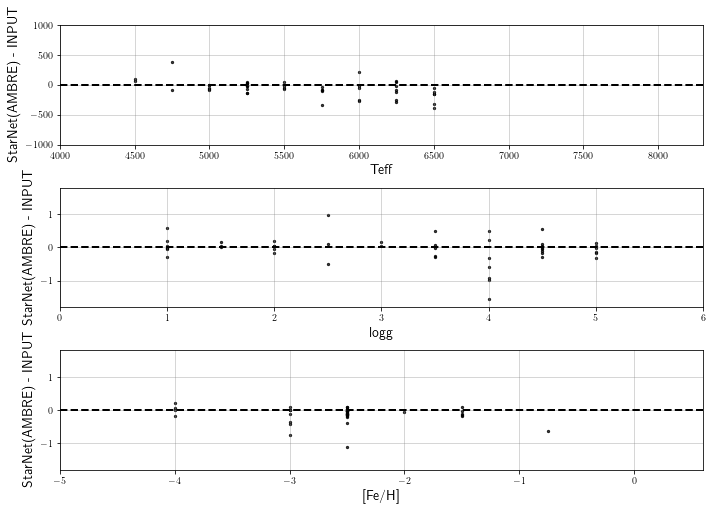

In [23]:
%matplotlib inline

fig, axes = plt.subplots(3, 1, figsize=(10, 7))

# Plot teff
axes[0].scatter(teff_input, 
                all_pred['teff'] - teff_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[0].set_xlabel('Teff', size=14)
axes[0].set_ylim((-1000, 1000))
axes[0].set_xlim((4000, 8300))
axes[0].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot logg
axes[1].scatter(logg_input, 
                all_pred['logg'] - logg_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[1].set_xlabel('logg', size=14)
axes[1].set_ylabel('StarNet(AMBRE) - INPUT', size=14)
axes[1].set_ylim((-1.8, 1.8))
axes[1].set_xlim((0, 6))
axes[1].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot feh
axes[2].scatter(feh_input, 
                all_pred['m_h'] - feh_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[2].set_xlabel('[Fe/H]', size=14)
axes[2].set_ylim((-1.8, 1.8))
axes[2].set_xlim((-5, 0.6))
axes[2].axhline(0, linewidth=2, c='black', linestyle='--')

plt.tight_layout()